# Desafio 2: Raspador de diários

Neste desafio você irá acessar o sistema de publicação de diários da prefeitura de Paulínia-SP e coletar as informações disponíveis!

Antes de começar o desafio, [acesse o site](http://paulinia.sp.gov.br/semanarios) para ir se familiarizando.


Lembre-se que as Ferramentas de Desenvolvimento do Chrome são essenciais nesse desafio!

## Objetivo

Aqui, vamos **criar um conjunto de dados das publicações dos diários oficiais**. Não iremos baixar os arquivos, iremos apenas coletar **suas URLs e outras informações que estejam disponíveis**, que é uma parte do objetivo do [Querido Diário](https://queridodiario.ok.org.br/).

Vamos analisar o site:

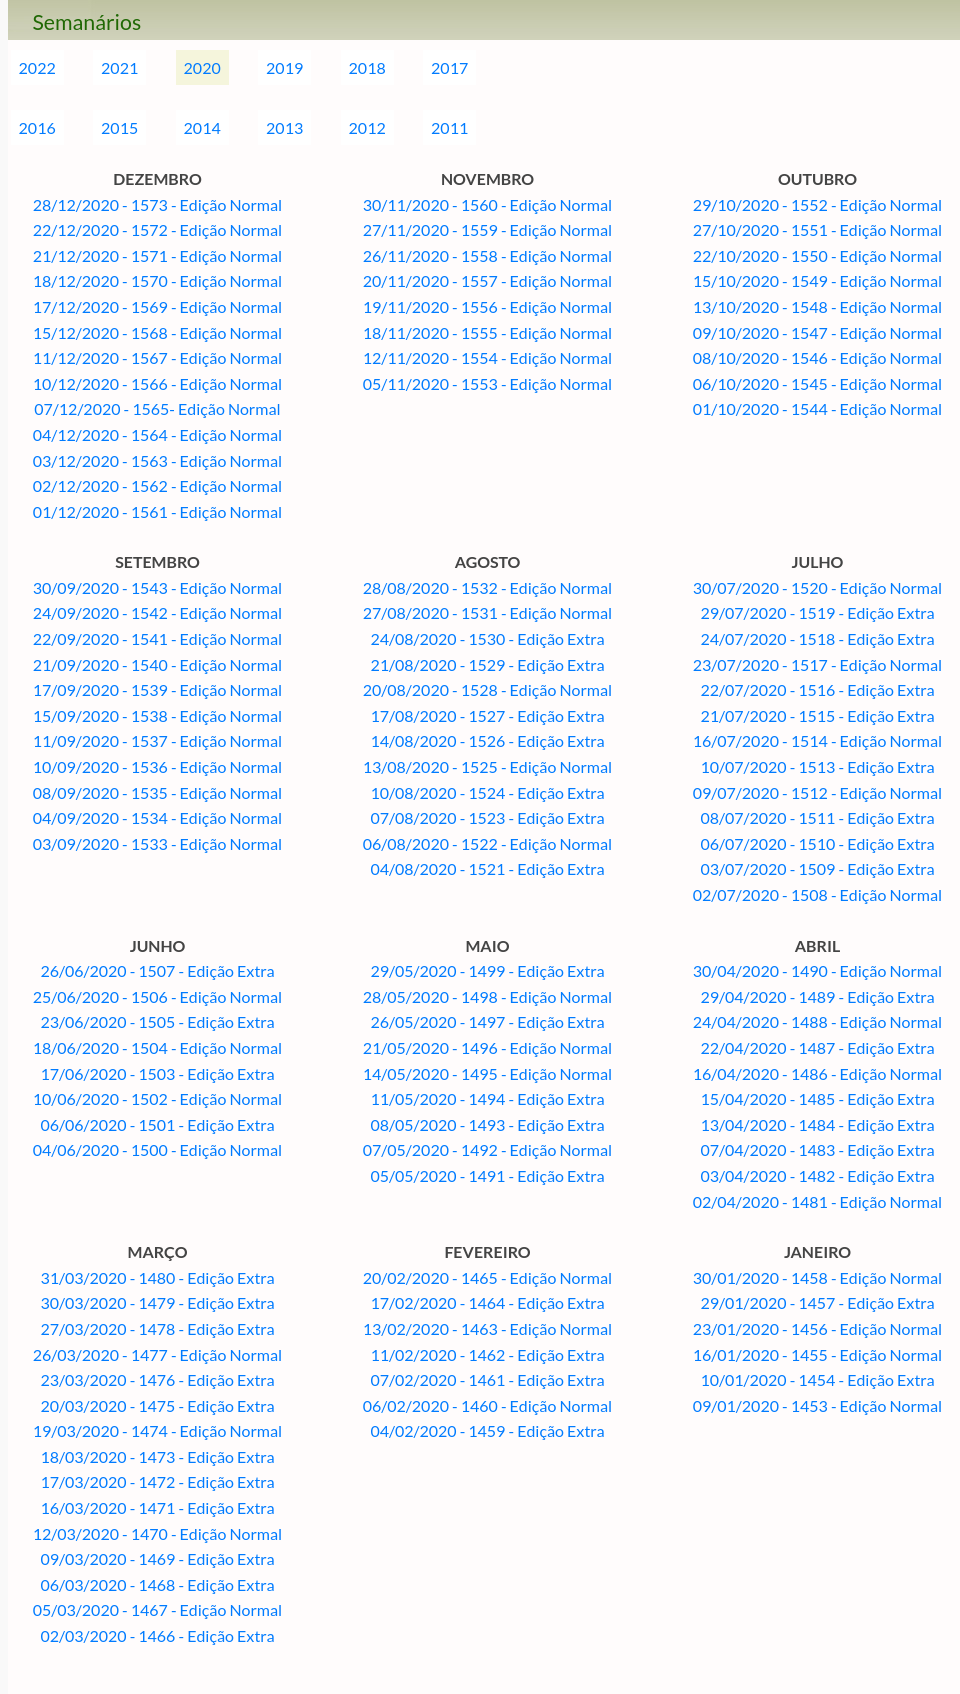

Podemos ver que as publicações são disponibilizadas em forma de listas para cada ano. Então vamos elaborar novamente um possível passo-a-passo de como coletar as informações de **todas** as publicações disponíveis:
1. Investigar como podemos requisitar as páginas para cada ano de publicação com o Inspetor de Redes
2. Investigar a disposição dos elementos na página com o Inspetor de Elementos
3. Investigar como obter as URLs dos documentos
4. Criar um raspador para uma página de publicação anual com `requests_html`
5. Implementar um raspador mais complexo que repita o passo anterior para cada ano disponível
6. Salvar o conteúdo em CSV

Vamos investigar!

*Caso não tenha as bibliotecas utilizadas no desafio instaladas, descomente a célula abaixo e a execute*

In [ ]:
# !pip install requests_html

## Investigando as requisições



Primeiro, a requisição inicial (verifique se suas configurações estão similares às mostradas abaixo):

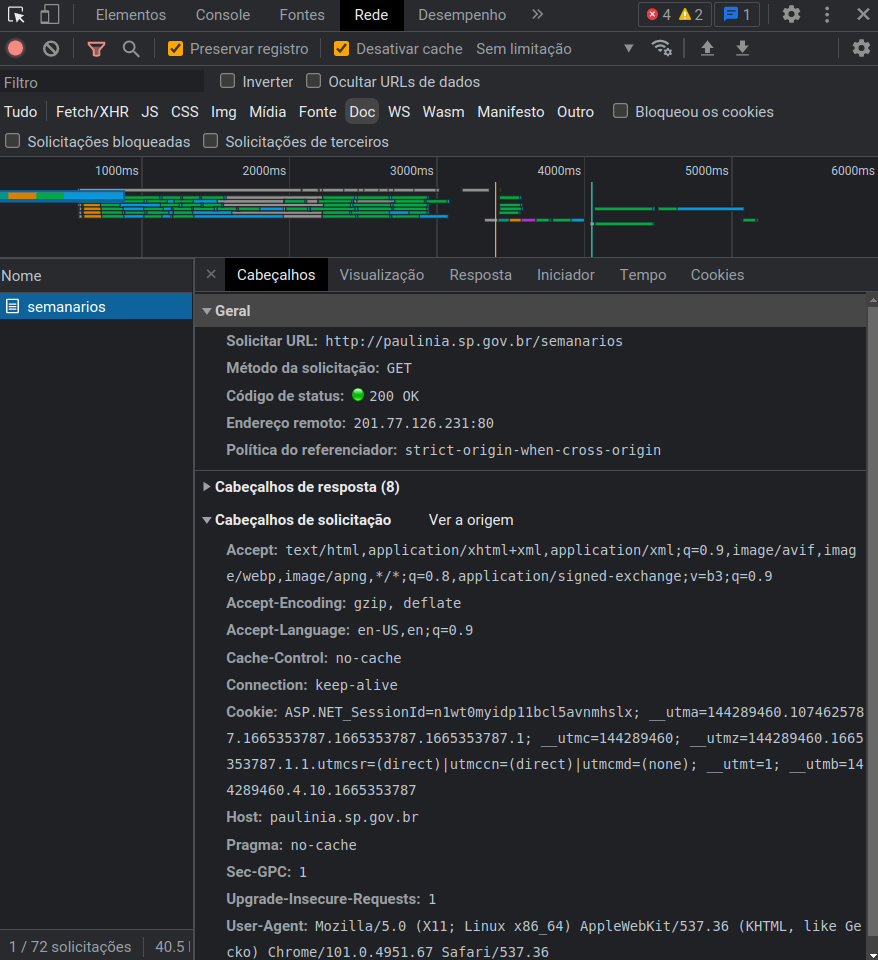

Observamos uma requisição `GET` que, ao investigar a **Resposta**, encontramos a lista de publicações da página inicial:

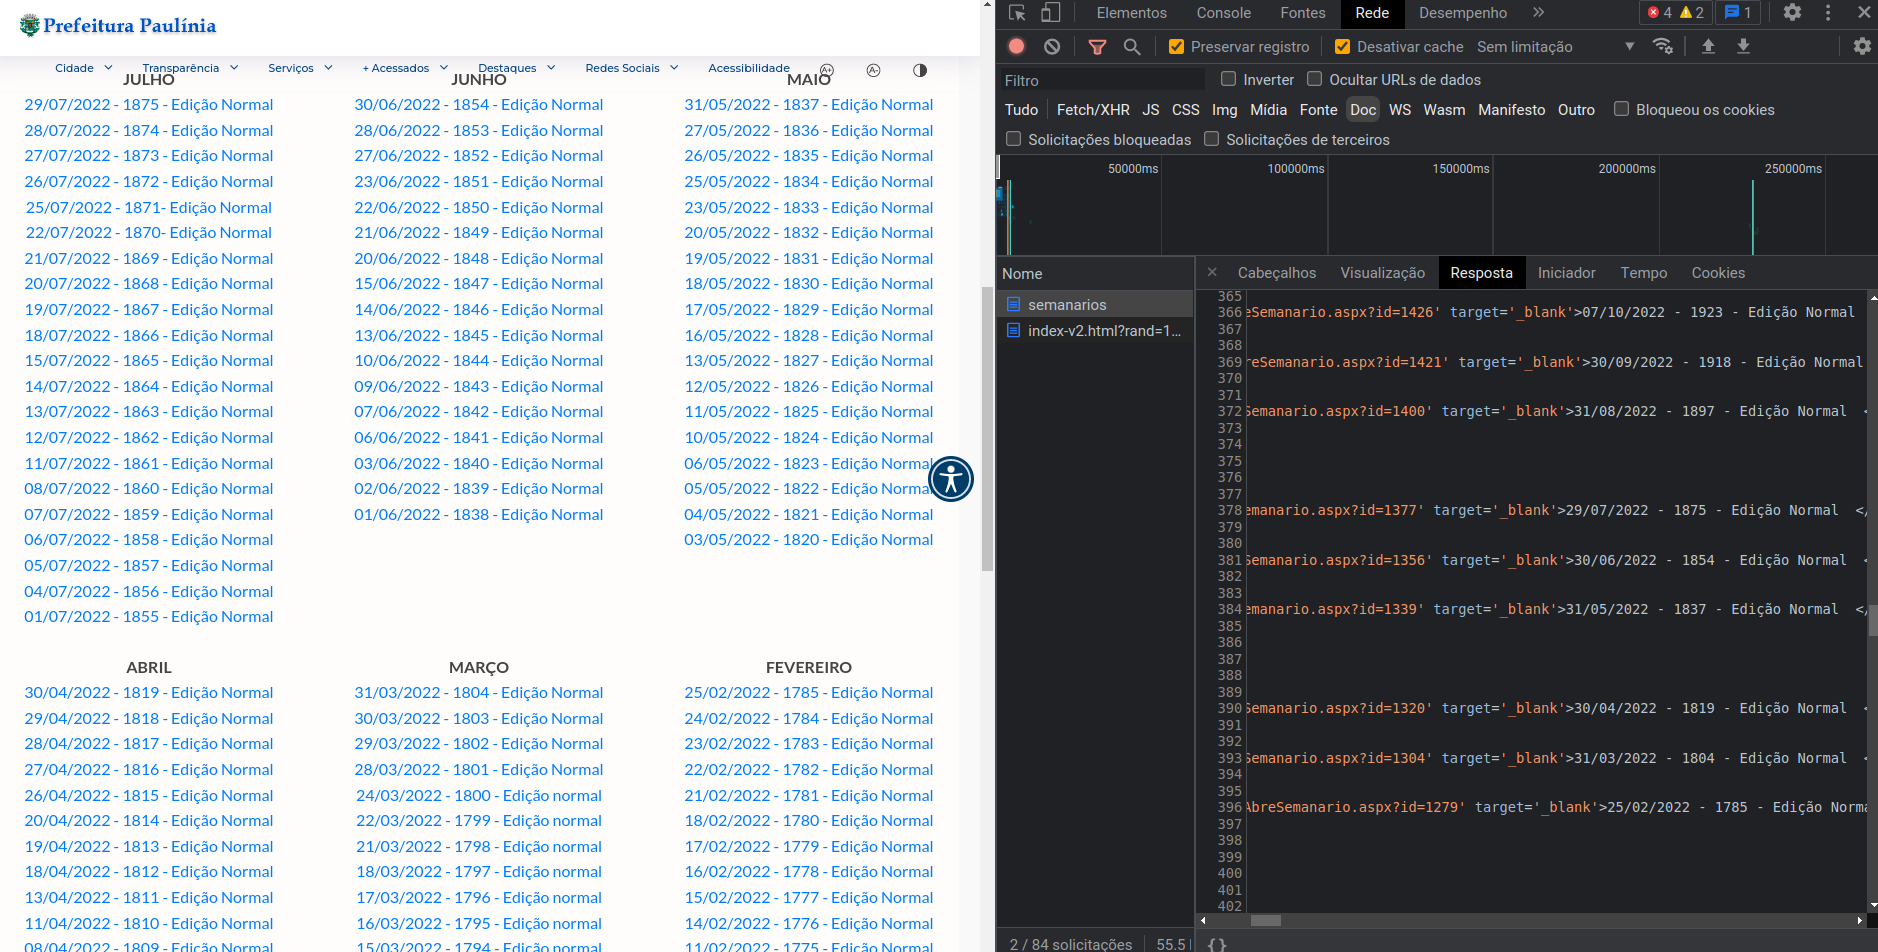

Precisamos observar o que acontece ao selecionar outro ano. Por exemplo, 2020:

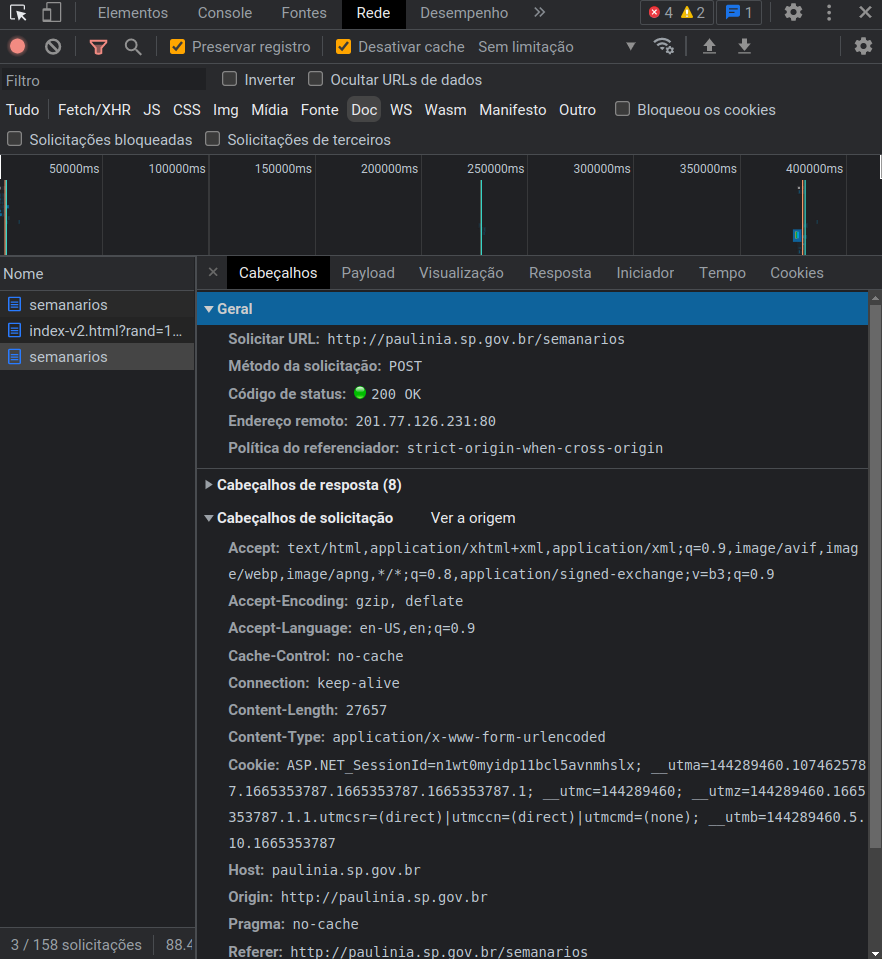

Aqui observamos que a requisição é `POST` e ao observarmos a **Resposta** como fizemos antes também encontramos os elementos que buscamos. Se essa requisição nos traz as informações que precisamos, então devemos ver o que é enviado no **Payload** para tentar replicá-la:

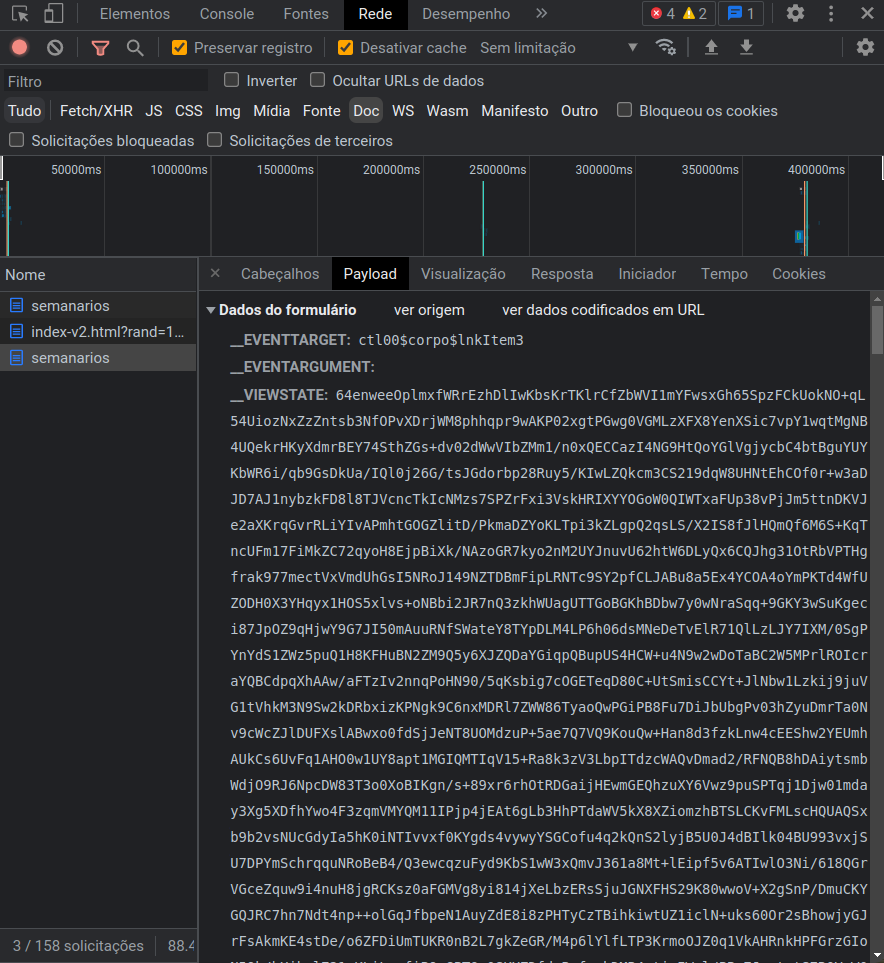

Em requisições `POST`, enviamos em seu corpo um documento (normalmente chave-valor como um JSON ou um dicionário Python) e com isso parâmetros diferentes podem trazem resultados diferentes mesmo que a URL da requisição seja a mesma. Este documento é comumente chamado de **Formdata** ou **Payload**.

Nessa requisição, aparecem cinco parâmetros no formdata, cujas chaves são:
- `__EVENTTARGET`
- `__EVENTARGUMENT`
- `__VIEWSTATE`
- `__VIEWSTATEGENERATOR`
- `__EVENTVALIDATION`

Com isso precisamos descobrir duas coisas:
1. Se requisitarmos outra página, os parâmetros serão os mesmos?
2. Como obter os valores para preencher o formdata corretamente?

Podemos investigar a primeira pergunta facilmente. Vamos ver como é o formdata da requisição ao clicarmos no ano de 2019:

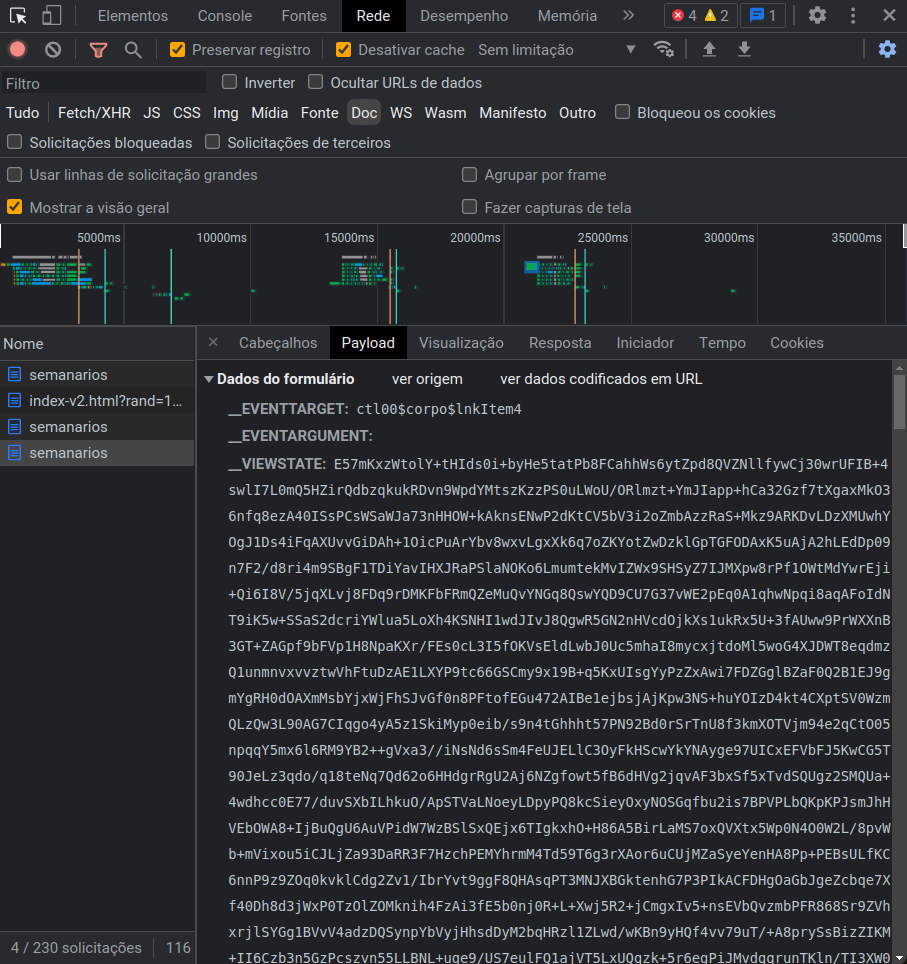

Observamos que todas as chaves permanecem iguais. Porém, os valores de `__EVENTTARGET`, `__VIEWSTATE` e `__EVENTVALIDATION` são alterados.

Agora podemos começar a responder a próxima pergunta.

Precisamos ter em mente que **todas as informações necessárias para replicar a requisição sempre estão ao nosso alcance**. Muitas vezes podem ser encontradas na página de resposta da requisição anterior, por exemplo. Sites mais difíceis de ter sua lógica de requisição replicada geram valores dinamicamente, através de Javascripts minificados. Mas até esses são possíveis de replicar, se tivermos tempo e paciência suficiente :) Ainda bem que não será necessário hoje!

Vamos procurar os valores de cada parâmetro na página anterior. Ou seja, antes de requisitar a página de 2019, vamos procurar os valores na resposta HTML de 2020:

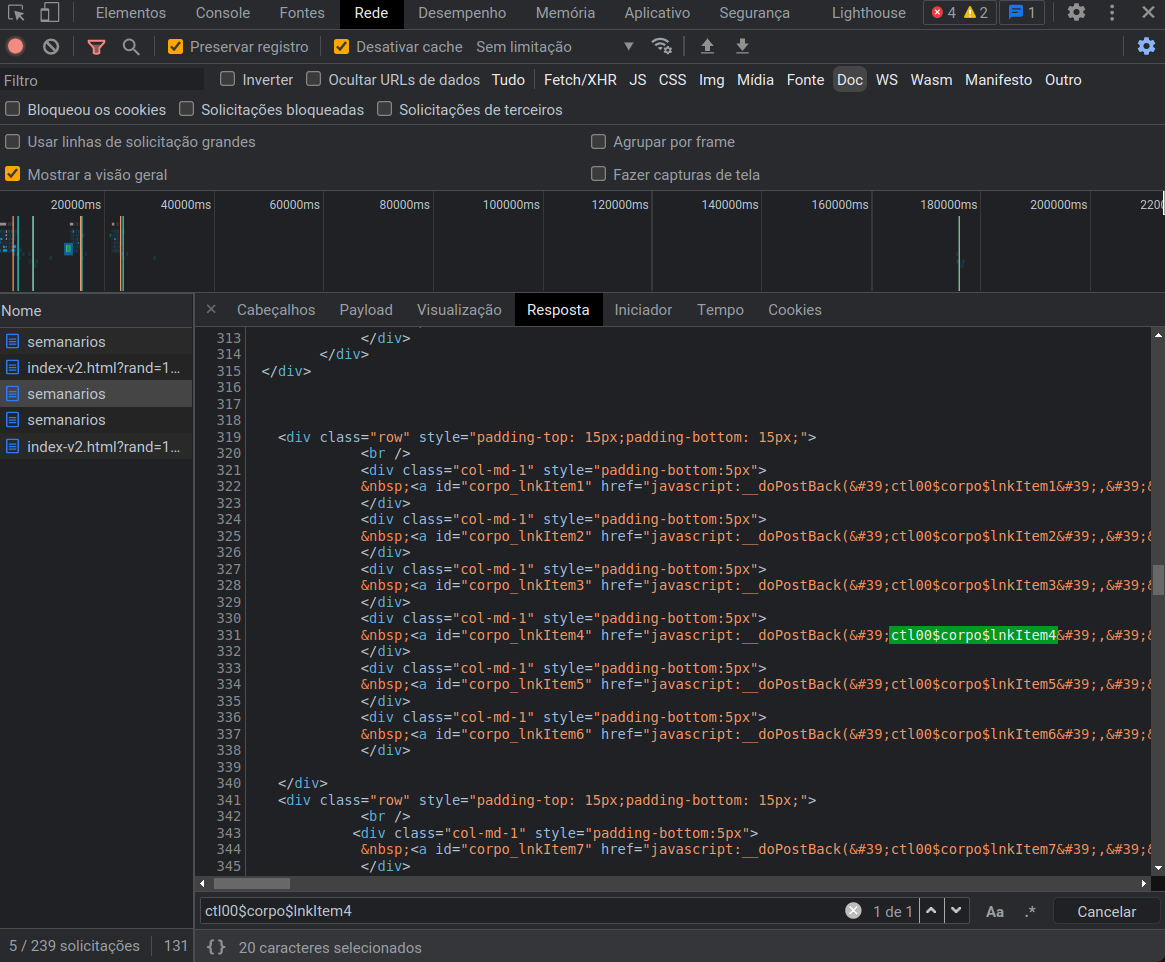

Buscando pelo valor `ctl00$corpo$lnkItem4` encontramos um elemento do tipo `a` que contém esse valor no atributo `href`. E podemos observar que cada ano disponível possui um valor específico para este atributo, começando em `ctl00$corpo$lnkItem1`.

**Qual XPath permite encontrar os elementos `a` de cada ano disponível?**

Resposta: ``

In [ ]:
xpath_anos_disponiveis = ""

Agora precisamos encontrar os outros parâmetros. Procurando por seus valores ou suas chaves conseguimos encontrá-los rapidamente:

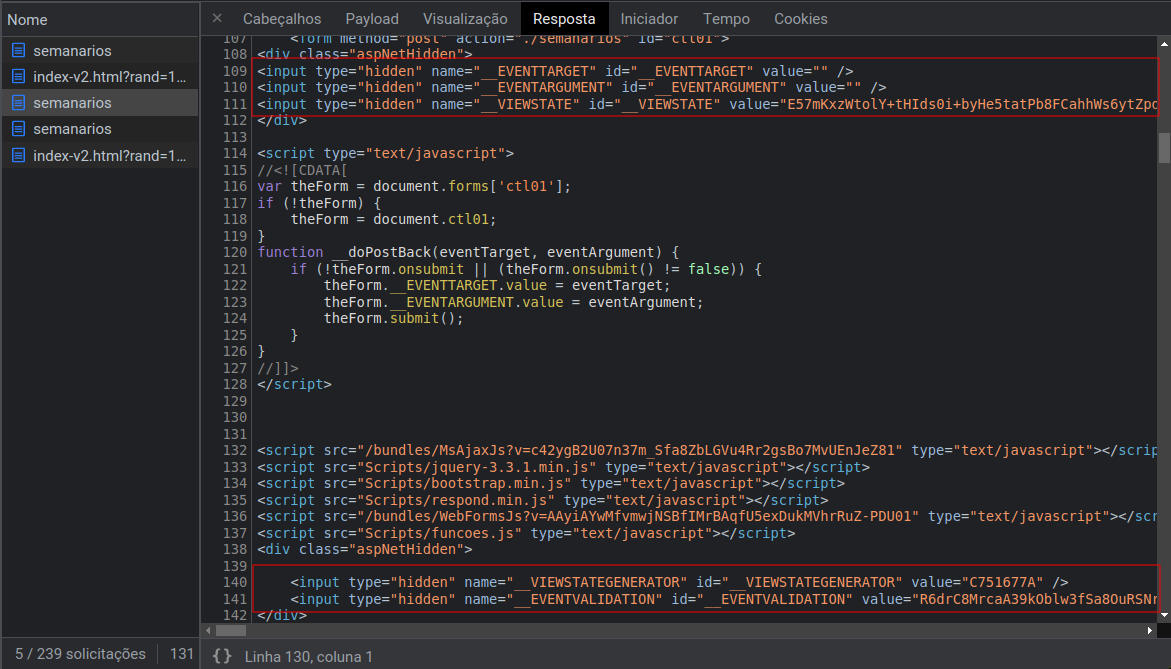

Encontramos todos e há um certo padrão entre todos os elementos.

**Qual padrão podemos identificar?**

Resposta: 

**Qual XPath permite encontrar todos esses elementos que usaremos para montar o formdata?**

Resposta: ``

In [ ]:
xpath_inputs = ""

Com isso conseguimos responder a segunda pergunta que nos fizemos durante a investigação!

## Investigando os elementos da lista de publicações

Agora precisamos ver como encontrar os elementos de cada publicação:

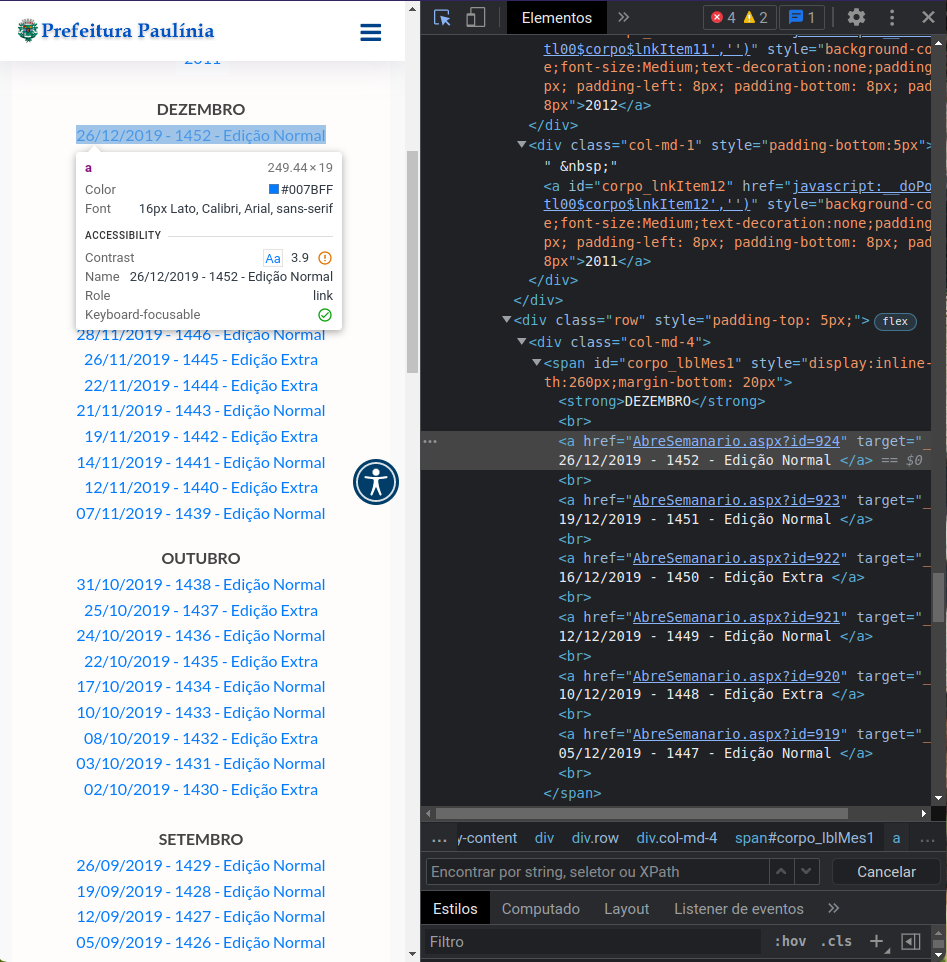

Todas as informações que estamos procurando estão contidas no texto ou em atributo desses elementos do tipo `a`.

**Em uma página de ano, qual XPath permite encontrar os elementos de cada publicação individual?**

Resposta: ``

In [ ]:
xpath_lista_publicacoes = ""

Mas será que o link no atributo `href` nos traria o documento?

## Investigando como obter a URL dos documentos

Primeiro, devemos garantir que temos a configuração "Abrir DevTools automaticamente para pop-ups" esteja ativada. Com isso, ao clicar em um documento, a nova aba já abrirá com o Inspetor de Redes e poderemos observar quais requisições foram realizadas. Do contrário, perdemos essa informação.

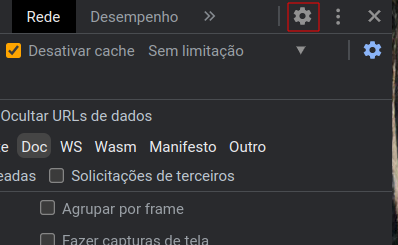

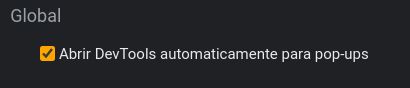

Retornando ao Inspetor de Rede e clicando em um link de publicação podemos ver que algumas requisições são feitas:

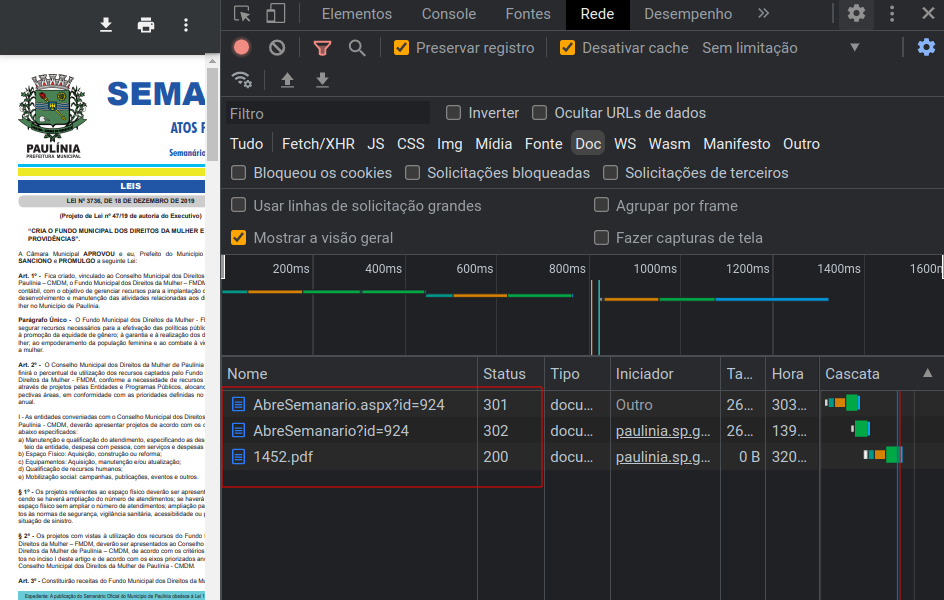

A última requisição da lista é a requisição que retorna o documento PDF na resposta de fato. Porém, antes dela algumas requisições são feitas.

Podemos observar os status dessas requisições. `301` e `302` são status de redirecionamento. Então, vamos assumir que ao fazer uma requisição para a URL disponibilizada no elemento da lista, nossa requisição será redirecionada automaticamente para o documento PDF. Com isso, obtendo o link original, seria o mesmo que obter o link final direto para o PDF.

## Criando um raspador para a página inicial

Agora vamos criar um raspador para a página inicial com os XPaths que já obtivemos. Vamos obter a URL de cada publicação apresentada na página e o texto que contém a data de publicação, número de edição e informação sobre a edição ser ordinária ou extra.

In [ ]:
from requests_html import HTMLSession

url_base = "http://paulinia.sp.gov.br"
url_principal = f"{url_base}/semanarios"

In [ ]:
sessao = HTMLSession()
pagina_inicial = sessao.get(url_principal)

In [ ]:
publicacoes_na_pagina = pagina_inicial.html.xpath(xpath_lista_publicacoes)
publicacoes_na_pagina

In [ ]:
publicacoes = []
for elemento in publicacoes_na_pagina:
  titulo = elemento.text
  link = elemento.attrs['href']
  publicacoes.append({"titulo": titulo, "link": f"{url_base}/{link}"})

publicacoes

Com a base montada desse jeito já poderíamos salvar em CSV. Mas ainda falta requisitar as páginas de outros anos.

## Coletando informações de todos os anos disponíveis

Primeiro coletaremos as chaves e valores dos parâmetros que vimos ser necessários para montar o formdata anteriormente:

In [ ]:
formdata_base = {}
inputs = pagina_inicial.html.xpath(xpath_inputs)
for elemento in inputs:
  formdata_base[elemento.attrs['name']] = elemento.attrs['value']

formdata_base

Agora podemos criar as requisições utilizando este dicionário como base:

In [ ]:
anos_disponiveis = pagina_inicial.html.xpath(xpath_anos_disponiveis)
for elemento in anos_disponiveis:
  ano = elemento.text
  href = elemento.attrs['href']
  print({"ano": ano, "href": href})

Precisamos selecionar o conteúdo do atributo `href` que nos interessa, descartando o resto. Para isso, vamos utilizar REGEX!

**Qual regex seleciona da string de `href` apenas o valor que temos interesse para montar o parâmetro da requisição?**

Resposta: ``

In [ ]:
import re

regex_parametro_href = re.compile(r"")

In [ ]:
anos_disponiveis = pagina_inicial.html.xpath(xpath_anos_disponiveis)
for elemento in anos_disponiveis:
  ano = elemento.text
  href = elemento.attrs['href']
  print({"ano": ano, "__EVENTTARGET": re.search(regex_parametro_href, href).group(1)})

Temos tudo que é necessário para fazer nosso raspador completo agora:

In [ ]:
formdata_base = {}
inputs = pagina_inicial.html.xpath(xpath_inputs)
for elemento in inputs:
  formdata_base[elemento.attrs['name']] = elemento.attrs['value']

publicacoes = []
anos_disponiveis = pagina_inicial.html.xpath(xpath_anos_disponiveis)
for elemento in anos_disponiveis:
  ano = elemento.text
  print(f"Coletando ano: {ano}")
  href = elemento.attrs['href']
  formdata_base["__EVENTTARGET"] = re.search(regex_parametro_href, href).group(1)

  pagina_ano = sessao.post(url_principal, data=formdata_base.copy())
  
  publicacoes_na_pagina = pagina_ano.html.xpath(xpath_lista_publicacoes)
  for elemento in publicacoes_na_pagina:
    titulo = elemento.text
    link = elemento.attrs['href']
    publicacoes.append({"titulo": titulo, "link": f"{url_base}/{link}"})

publicacoes

## Salvando em CSV

Coletamos todas as informações que desejamos. Vamos salvar em CSV? Esse desafio fica com você!

Com isso, concluímos o raspador. Mais um pra nossa lista!

Se deseja um desafio extra e deseja praticar regex, tente segmentar o título da publicação nos campos `numero_edicao`, `data_publicacao` e `edicao_extra_ou_ordinaria`!